## Classificatore

In [1]:
import pandas as pd
import numpy as np
import re
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns

W0608 18:06:33.782000 23524 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


## Pulizia dei dati

In [2]:
import pandas as pd

# Caricamento del dataset locale (versionato con DVC)
df = pd.read_csv("../data/raw/reviews/amazon_beauty_reviews.csv")

print(df.iloc[0])


rating                                                             5.0
title                        Such a lovely scent but not overpowering.
text                 This spray is really nice. It smells really go...
images                                                              []
asin                                                        B00YQ6X8EO
parent_asin                                                 B00YQ6X8EO
user_id                                   AGKHLEW2SOWHNMFQIJGBECAF7INQ
timestamp                                                1588687728923
helpful_vote                                                         0
verified_purchase                                                 True
Name: 0, dtype: object


In [3]:
df

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True
...,...,...,...,...,...,...,...,...,...,...
701523,4.0,Four Stars,Conditioner is great shampoo not as I expected,[],B006YUIWKA,B006YUIWKA,AFIXGFVEGLMOTMBTJL7H3VSIETDQ,1478227021000,0,True
701524,1.0,Pretty,Did not work! Used the whole bottle and my hai...,[],B006YUIWKA,B006YUIWKA,AFV7YZFOJF564EZGET5LG45K4QEA,1480908730000,0,False
701525,5.0,Great sunless tanner,Product as expected. Shipping was on time.,[],B06ZZV9MZT,B06ZZV9MZT,AHYDCWDMMVMLBX7FY7M7JKADKRDQ,1590547974067,0,True
701526,5.0,The Crown on top is a Ring!!!,"Not only is it a delicious fragrance, but also...",[],B000HB6VLE,B000HB6VLE,AF6ZIAEN7TQ2WY5ZL77F6JDPV7XQ,1184798209000,4,False


In [4]:
# Uniformare i valori null
null_equivalents = ["^NaN$", "^na$", "^NA$", "^null$", "^None$", "^N/A$", "^n/a$", "^\s*$"]
df.replace(to_replace=null_equivalents, value=np.nan, regex=True, inplace=True)

# Filtra solo le righe con text e rating validi
df_clean = df[["text", "rating"]].dropna(subset=["text", "rating"])

# Resetta gli indici
df_clean = df_clean.reset_index(drop=True)

# Controllo
print("Shape finale:", df_clean.shape)
print(df_clean.head())

Shape finale: (700690, 2)
                                                text  rating
0  This spray is really nice. It smells really go...     5.0
1  This product does what I need it to do, I just...     4.0
2                          Smells good, feels great!     5.0
3                                     Felt synthetic     1.0
4                                            Love it     5.0


In [5]:
import requests

url = "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz"
r = requests.get(url)

with open("lid.176.ftz", "wb") as f:
    f.write(r.content)

print("✅ Modello scaricato con successo!")

✅ Modello scaricato con successo!


In [6]:
import fasttext

# Carica il modello (deve essere nella stessa cartella!)
model = fasttext.load_model("lid.176.ftz")

# Funzione per rilevare la lingua
def get_lang(text):
    try:
        prediction = model.predict(str(text))
        lang = prediction[0][0].replace("__label__", "")
        return lang
    except:
        return "unknown"
    

# Pulisci dati
df_clean = df_clean[df_clean["text"].notna()]
df_clean = df_clean[df_clean["text"].str.len() > 0]

# Rileva lingua
df_clean["lang"] = df_clean["text"].apply(get_lang)

# Rimuovi frasi in spagnolo
df_clean = df_clean[df_clean["lang"] != "es"]
df_clean = df_clean.drop(columns=["lang"])

In [7]:
df_clean

,text,rating
0,This spray is really nice. It smells really go...,5.0
1,"This product does what I need it to do, I just...",4.0
2,"Smells good, feels great!",5.0
3,Felt synthetic,1.0
4,Love it,5.0
...,...,...
700685,Conditioner is great shampoo not as I expected,4.0
700686,Did not work! Used the whole bottle and my hai...,1.0
700687,Product as expected. Shipping was on time.,5.0
700688,"Not only is it a delicious fragrance, but also...",5.0


In [8]:
import re
import emoji
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

# Fun per pulizia e normalizzazione
def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Rimozione emoji
    text = emoji.replace_emoji(text, replace='')
    
    # 3. Rimozione URL e HTML
    text = re.sub(r"http\S+|www\S+|<.*?>", " ", text)
    
    # 4. Rimozione punteggiatura (ma lascia apostrofi utili)
    text = re.sub(r"[^\w\s']", " ", text)
    
    # 5. Rimozione numeri
    text = re.sub(r"\d+", " ", text)
    
    # 6. Rimozione stopword
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    # 7. Ricomponi e rimuovi spazi multipli
    text = " ".join(words)
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

df_clean["text_cleaned"] = df_clean["text"].astype(str).apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rosac\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
import contractions
import re

# Espansione contrazioni
def expand_contractions(text):
    return contractions.fix(text)

# Marcatura delle negazioni (opzionale ma utile per TF-IDF + ML classico)
def mark_negations(text):
    negation_words = {"not", "no", "never", "n't"}
    words = text.split()
    result = []
    negating = False

    for word in words:
        if any(neg in word for neg in negation_words):
            negating = True
            result.append(word)
        elif negating:
            result.append("NOT_" + word)
            if any(punct in word for punct in [".", ",", "!", "?", ";"]):
                negating = False
        else:
            result.append(word)
    return " ".join(result)


# Espandi contrazioni
df_clean["text_expanded"] = df_clean["text_cleaned"].apply(expand_contractions)

# (Facoltativo) Marca negazioni
df_clean["text_final"] = df_clean["text_expanded"].apply(mark_negations)

df_clean

,text,rating,text_cleaned,text_expanded,text_final
0,This spray is really nice. It smells really go...,5.0,spray really nice smells really good goes real...,spray really nice smells really good goes real...,spray really nice smells really good goes real...
1,"This product does what I need it to do, I just...",4.0,product need wish odorless soft coconut smell ...,product need wish odorless soft coconut smell ...,product need wish odorless soft coconut smell ...
2,"Smells good, feels great!",5.0,smells good feels great,smells good feels great,smells good feels great
3,Felt synthetic,1.0,felt synthetic,felt synthetic,felt synthetic
4,Love it,5.0,love,love,love
...,...,...,...,...,...
700685,Conditioner is great shampoo not as I expected,4.0,conditioner great shampoo expected,conditioner great shampoo expected,conditioner great shampoo expected
700686,Did not work! Used the whole bottle and my hai...,1.0,work used whole bottle hair feels thinner pret...,work used whole bottle hair feels thinner pret...,work used whole bottle hair feels thinner pret...
700687,Product as expected. Shipping was on time.,5.0,product expected shipping time,product expected shipping time,product expected shipping time
700688,"Not only is it a delicious fragrance, but also...",5.0,delicious fragrance also crown jewel let every...,delicious fragrance also crown jewel let every...,delicious fragrance also crown jewel let every...


In [10]:
# Rimozione dei duplicati
df_clean = df_clean.drop_duplicates(subset=["text_final"])

In [11]:
from textblob import TextBlob

# 1. Calcolo della polarità sul testo preprocessato
df_clean["polarity_final"] = df_clean["text_final"].apply(lambda x: TextBlob(x).sentiment.polarity)

# 2. Calcolo della lunghezza del testo in numero di parole
df_clean["text_len"] = df_clean["text_final"].apply(lambda x: len(x.split()))


C:\Users\rosac\AppData\Local\Temp\ipykernel_23524\1187685829.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["polarity_final"] = df_clean["text_final"].apply(lambda x: TextBlob(x).sentiment.polarity)
C:\Users\rosac\AppData\Local\Temp\ipykernel_23524\1187685829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["text_len"] = df_clean["text_final"].apply(lambda x: len(x.split()))


In [12]:
# 2. Calcolo dei baffi per rating 3 (per identificare neutri coerenti)
q3 = df_clean[df_clean["rating"] == 3]["polarity_final"].quantile([0.25, 0.75])
iqr3 = q3[0.75] - q3[0.25]
lower3 = q3[0.25] - 1.5 * iqr3
upper3 = q3[0.75] + 1.5 * iqr3

# 3. Funzione per identificare recensioni incoerenti
def is_incoherent(row):
    r, p = row["rating"], row["polarity_final"]
    if r in [1, 2] and p >= 0:
        return True
    elif r == 3 and not (lower3 <= p <= upper3):
        return True
    elif r in [4, 5] and p <= 0:
        return True
    return False

# 4. Applica la funzione e filtra incoerenti + testi corti
df_clean["incoerente"] = df_clean.apply(is_incoherent, axis=1)
df_clean = df_clean[(df_clean["incoerente"] == False) & (df_clean["text_len"] >= 3)].copy()
df_clean = df_clean.drop(columns=["incoerente"])



C:\Users\rosac\AppData\Local\Temp\ipykernel_23524\1106160874.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["incoerente"] = df_clean.apply(is_incoherent, axis=1)


In [13]:
# 5. Mappatura rating → sentiment_class (0=neg, 1=neutro, 2=positivo)
def map_rating_to_sentiment(rating):
    if rating in [1, 2]:
        return 0
    elif rating == 3:
        return 1
    else:  # rating 4, 5
        return 2

df_clean["sentiment_class"] = df_clean["rating"].apply(map_rating_to_sentiment)

In [14]:
df_clean

,text,rating,text_cleaned,text_expanded,text_final,polarity_final,text_len,sentiment_class
0,This spray is really nice. It smells really go...,5.0,spray really nice smells really good goes real...,spray really nice smells really good goes real...,spray really nice smells really good goes real...,0.572222,31,2
1,"This product does what I need it to do, I just...",4.0,product need wish odorless soft coconut smell ...,product need wish odorless soft coconut smell ...,product need wish odorless soft coconut smell ...,0.100000,20,2
2,"Smells good, feels great!",5.0,smells good feels great,smells good feels great,smells good feels great,0.750000,4,2
6,Great for many tasks. I purchased these for m...,5.0,great many tasks purchased makeup removal make...,great many tasks purchased makeup removal make...,great many tasks purchased makeup removal make...,0.550000,13,2
7,These were lightweight and soft but much too s...,3.0,lightweight soft much small liking would prefe...,lightweight soft much small liking would prefe...,lightweight soft much small liking would prefe...,-0.075000,14,1
...,...,...,...,...,...,...,...,...
700684,What I got was a completely different bottle t...,1.0,got completely different bottle one product fe...,got completely different bottle one product fe...,got completely different bottle one product fe...,-0.375000,13,0
700685,Conditioner is great shampoo not as I expected,4.0,conditioner great shampoo expected,conditioner great shampoo expected,conditioner great shampoo expected,0.350000,4,2
700686,Did not work! Used the whole bottle and my hai...,1.0,work used whole bottle hair feels thinner pret...,work used whole bottle hair feels thinner pret...,work used whole bottle hair feels thinner pret...,-0.100000,9,0
700688,"Not only is it a delicious fragrance, but also...",5.0,delicious fragrance also crown jewel let every...,delicious fragrance also crown jewel let every...,delicious fragrance also crown jewel let every...,1.000000,14,2


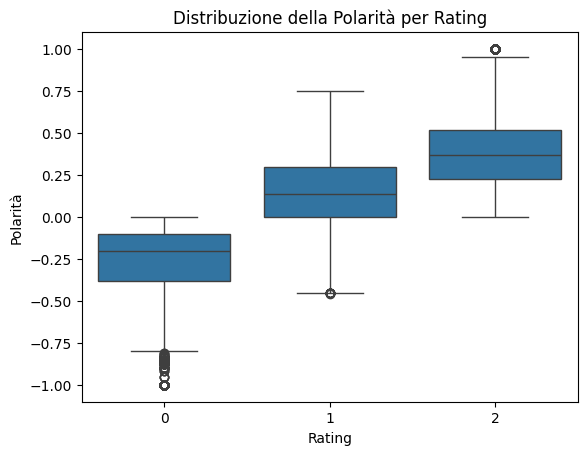

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assicurati che 'df_clean' contenga le colonne 'rating' e 'polarity'
sns.boxplot(data=df_clean, x="sentiment_class", y="polarity_final")
plt.title("Distribuzione della Polarità per Rating")
plt.xlabel("Rating")
plt.ylabel("Polarità")
plt.show()

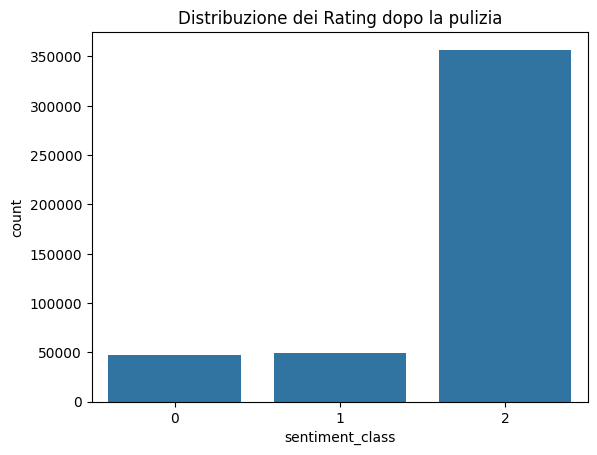

sentiment_class
2    356922
1     49574
0     47732
Name: count, dtype: int64


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df_clean, x="sentiment_class")
plt.title("Distribuzione dei Rating dopo la pulizia")
plt.show()

# Oppure:
print(df_clean["sentiment_class"].value_counts())


In [17]:
from sklearn.cluster import KMeans
from sklearn.utils import resample
import pandas as pd

# 1. Numero target = numero di elementi della classe 0
target_count = df_clean[df_clean["sentiment_class"] == 0].shape[0]

# 2. Numero di cluster (puoi regolarlo)
n_clusters = 5

# 3. Lista per salvare i sottodataset bilanciati
balanced_parts = []

# 4. Aggiungi la classe 0 così com'è
balanced_parts.append(df_clean[df_clean["sentiment_class"] == 0].copy())

# 5. Per ogni classe maggioritaria (1 e 2)
for cls in [1, 2]:
    subset = df_clean[df_clean["sentiment_class"] == cls].copy()

    # Applica clustering su polarity + text_len
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    subset["cluster"] = kmeans.fit_predict(subset[["polarity_final", "text_len"]])

    # Calcola quanti campioni prendere da ogni cluster
    samples_per_cluster = target_count // n_clusters
    sampled_clusters = []

    for c in range(n_clusters):
        cluster_df = subset[subset["cluster"] == c]
        sample = resample(cluster_df,
                          replace=False,
                          n_samples=min(samples_per_cluster, len(cluster_df)),
                          random_state=42)
        sampled_clusters.append(sample)

    # Se non hai raggiunto esattamente target_count (es. cluster piccoli), aggiusta:
    total_current = sum([len(df) for df in sampled_clusters])
    if total_current < target_count:
        remaining = subset[~subset.index.isin(pd.concat(sampled_clusters).index)]
        additional = resample(remaining,
                              replace=False,
                              n_samples=(target_count - total_current),
                              random_state=42)
        sampled_clusters.append(additional)

    balanced_parts.append(pd.concat(sampled_clusters))

# 6. Unisci tutto e shuffle
balanced_df = pd.concat(balanced_parts).sample(frac=1, random_state=42).reset_index(drop=True)

# 7. Controlla distribuzione finale
print("Distribuzione delle classi dopo undersampling:")
print(balanced_df["sentiment_class"].value_counts())


Distribuzione delle classi dopo undersampling:
sentiment_class
0    47732
2    47732
1    47732
Name: count, dtype: int64


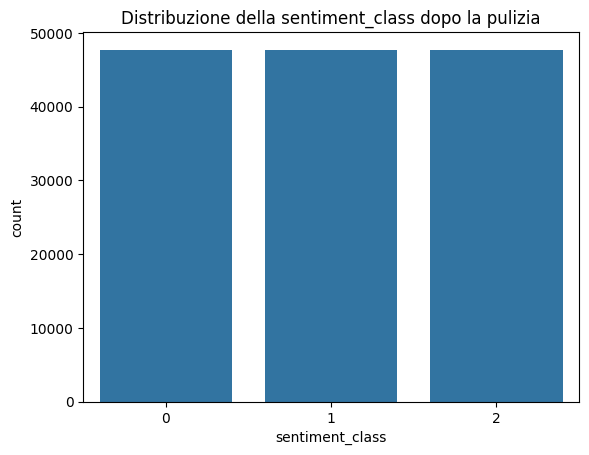

rating
3.0    47732
5.0    38794
1.0    36817
2.0    10915
4.0     8938
Name: count, dtype: int64


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=balanced_df, x="sentiment_class")
plt.title("Distribuzione della sentiment_class dopo la pulizia")
plt.show()

# Oppure:
print(balanced_df["rating"].value_counts())


In [19]:
balanced_df

,text,rating,text_cleaned,text_expanded,text_final,polarity_final,text_len,sentiment_class,cluster
0,Just buy a mask where the loops go around the ...,1.0,buy mask loops go around back head pointless,buy mask loops go around back head pointless,buy mask loops go around back head pointless,-0.125000,8,0,NaN
1,Couldn't get them out without tearing them. R...,1.0,get without tearing really made sad,get without tearing really made sad,get without tearing really made sad,-0.150000,6,0,NaN
2,Work well with certain masks that I have. Wer...,5.0,work well certain masks exactly described desc...,work well certain masks exactly described desc...,work well certain masks exactly described desc...,0.232143,7,2,0.0
3,Terrible item. Wish I could give negative stars.,1.0,terrible item wish could give negative stars,terrible item wish could give negative stars,terrible item wish could give negative stars,-0.650000,7,0,NaN
4,Cleanses well and leaves face very soft.,5.0,cleanses well leaves face soft,cleanses well leaves face soft,cleanses well leaves face soft,0.100000,5,2,0.0
...,...,...,...,...,...,...,...,...,...
143191,These is the third masque I got from this bran...,5.0,third masque got brand even skin improvements ...,third masque got brand even skin improvements ...,third masque got brand even skin improvements ...,0.116667,48,2,2.0
143192,It took me a few times to get the hang of my w...,5.0,took times get hang waver way videos showed aw...,took times get hang waver way videos showed aw...,took times get hang waver way videos showed aw...,0.025000,36,2,3.0
143193,"This smells wonderful, isn’t greasy or thick, ...",5.0,smells wonderful greasy thick makes hands feel...,smells wonderful greasy thick makes hands feel...,smells wonderful greasy thick makes hands feel...,0.266667,8,2,0.0
143194,"Allows me to bead my daughter's hair faster, h...",5.0,allows bead daughter's hair faster holds lot c...,allows bead daughter's hair faster holds lot c...,allows bead daughter's hair faster holds lot c...,0.300000,10,2,0.0


In [20]:
balanced_df = balanced_df[["text_final", "sentiment_class", "polarity_final", "text_len"]].copy()

In [21]:
balanced_df 

,text_final,sentiment_class,polarity_final,text_len
0,buy mask loops go around back head pointless,0,-0.125000,8
1,get without tearing really made sad,0,-0.150000,6
2,work well certain masks exactly described desc...,2,0.232143,7
3,terrible item wish could give negative stars,0,-0.650000,7
4,cleanses well leaves face soft,2,0.100000,5
...,...,...,...,...
143191,third masque got brand even skin improvements ...,2,0.116667,48
143192,took times get hang waver way videos showed aw...,2,0.025000,36
143193,smells wonderful greasy thick makes hands feel...,2,0.266667,8
143194,allows bead daughter's hair faster holds lot c...,2,0.300000,10


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix
import joblib

# Prepara testi, target e feature numeriche
texts = balanced_df["text_final"]
y = balanced_df["sentiment_class"]
extra_features = balanced_df[["polarity_final", "text_len"]].values

# Crea trasformatori
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
scaler = StandardScaler()


Configurazione MLflow per DagsHub

In [23]:
import mlflow
from dagshub import dagshub_logger
import os
from dotenv import load_dotenv

load_dotenv()

mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI"))
mlflow.set_experiment("multi-class-comparison")


<Experiment: artifact_location='mlflow-artifacts:/b2dd1ca643c046919d1e0b5be5ba9906', creation_time=1749214029684, experiment_id='4', last_update_time=1749214029684, lifecycle_stage='active', name='multi-class-comparison', tags={}>

### Training

In [24]:
from sklearn.model_selection import train_test_split
# Scaling delle feature numeriche
from scipy.sparse import csr_matrix
import os

# Split testi, target e feature numeriche
texts_train, texts_temp, y_train, y_temp, extra_train, extra_temp = train_test_split(
    texts, y, extra_features, test_size=0.4, stratify=y, random_state=42
)
texts_val, texts_test, y_val, y_test, extra_val, extra_test = train_test_split(
    texts_temp, y_temp, extra_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Vettorizzazione testi
X_train_tfidf = tfidf.fit_transform(texts_train)
X_val_tfidf = tfidf.transform(texts_val)
X_test_tfidf = tfidf.transform(texts_test)


X_train_extra = csr_matrix(scaler.fit_transform(extra_train))
X_val_extra = csr_matrix(scaler.transform(extra_val))
X_test_extra = csr_matrix(scaler.transform(extra_test))
joblib.dump(scaler, "xgboost/scaler.pkl")

# Merge TF-IDF + numeriche
X_train = hstack([X_train_tfidf, X_train_extra])
X_val = hstack([X_val_tfidf, X_val_extra])
X_test = hstack([X_test_tfidf, X_test_extra])


SVM

In [25]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow

os.makedirs("svm", exist_ok=True)

with mlflow.start_run(run_name="SVM_Model"):
    mlflow.log_param("model_type", "LinearSVC")
    mlflow.log_param("split", "60/20/20")
    mlflow.log_param("class_weight", "balanced")

    # Addestramento
    svm_model = LinearSVC(class_weight="balanced", random_state=42)
    svm_model.fit(X_train, y_train)

    # Validazione
    y_val_pred = svm_model.predict(X_val)
    mlflow.log_metric("val_accuracy", accuracy_score(y_val, y_val_pred))
    mlflow.log_metric("val_f1", f1_score(y_val, y_val_pred, average="macro"))

    # Test
    y_test_pred = svm_model.predict(X_test)
    mlflow.log_metric("test_accuracy", accuracy_score(y_test, y_test_pred))
    mlflow.log_metric("test_f1", f1_score(y_test, y_test_pred, average="macro"))
    mlflow.log_metric("test_precision", precision_score(y_test, y_test_pred, average="macro"))
    mlflow.log_metric("test_recall", recall_score(y_test, y_test_pred, average="macro"))

    # Salvataggi per explainability
    joblib.dump(svm_model, "svm/svm_model.pkl")
    joblib.dump(X_test, "svm/X_test.pkl")
    joblib.dump(y_test, "svm/y_test.pkl")
    joblib.dump(texts_test.tolist(), "svm/texts_test.pkl")
    joblib.dump(tfidf, "svm/vectorizer.pkl")

    # MLflow artifacts
    mlflow.log_artifact("svm/svm_model.pkl")
    mlflow.log_artifact("svm/X_test.pkl")
    mlflow.log_artifact("svm/y_test.pkl")
    mlflow.log_artifact("svm/texts_test.pkl")
    mlflow.log_artifact("svm/vectorizer.pkl")


🏃 View run SVM_Model at: https://dagshub.com/Fxller/se4ai-project.mlflow/#/experiments/4/runs/472f6ee616aa49e6b90bfe402e4fec67
🧪 View experiment at: https://dagshub.com/Fxller/se4ai-project.mlflow/#/experiments/4


XGBoost

In [26]:
import xgboost as xgb
import yaml
import json

os.makedirs("xgboost", exist_ok=True)

with open("../params.yaml") as f:
    params = yaml.safe_load(f)

xgb_params = params["xgboost"]

with mlflow.start_run(run_name="XGBoost_Model"):
    mlflow.log_param("model_type", "XGBoost")
    mlflow.log_param("split", "60/20/20")  # se vuoi puoi anche parametrizzare questa
    mlflow.log_param("n_estimators", xgb_params["n_estimators"])
    mlflow.log_param("learning_rate", xgb_params["learning_rate"])
    mlflow.log_param("max_depth", xgb_params["max_depth"])

    # Addestramento
    xgb_model = xgb.XGBClassifier(
    objective=xgb_params["objective"],
    num_class=xgb_params["num_class"],
    eval_metric=xgb_params["eval_metric"],
    use_label_encoder=False,
    n_estimators=xgb_params["n_estimators"],
    learning_rate=xgb_params["learning_rate"],
    max_depth=xgb_params["max_depth"],
    random_state=xgb_params["random_state"]
    )

    xgb_model.fit(X_train, y_train)

    # Validazione
    y_val_pred = xgb_model.predict(X_val)
    mlflow.log_metric("val_accuracy", accuracy_score(y_val, y_val_pred))
    mlflow.log_metric("val_f1", f1_score(y_val, y_val_pred, average="macro"))

    # Test
    y_test_pred = xgb_model.predict(X_test)
    mlflow.log_metric("test_accuracy", accuracy_score(y_test, y_test_pred))
    mlflow.log_metric("test_f1", f1_score(y_test, y_test_pred, average="macro"))
    mlflow.log_metric("test_precision", precision_score(y_test, y_test_pred, average="macro"))
    mlflow.log_metric("test_recall", recall_score(y_test, y_test_pred, average="macro"))

    # Salva le metriche anche su metrics.json per DVC
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average="macro")
    test_precision = precision_score(y_test, y_test_pred, average="macro")
    test_recall = recall_score(y_test, y_test_pred, average="macro")

    metrics = {
        "test_accuracy": test_accuracy,
        "test_f1": test_f1,
        "test_precision": test_precision,
        "test_recall": test_recall
    }

    with open("xgboost/metrics.json", "w") as f:
        json.dump(metrics, f, indent=2)
        
    # Salvataggi per explainability
    joblib.dump(xgb_model, "xgboost/xgb_model.pkl")
    joblib.dump(X_test, "xgboost/X_test.pkl")
    joblib.dump(y_test, "xgboost/y_test.pkl")
    joblib.dump(texts_test.tolist(), "xgboost/texts_test.pkl")
    joblib.dump(tfidf, "xgboost/vectorizer.pkl")

    # MLflow artifacts
    mlflow.log_artifact("xgboost/xgb_model.pkl")
    mlflow.log_artifact("xgboost/X_test.pkl")
    mlflow.log_artifact("xgboost/y_test.pkl")
    mlflow.log_artifact("xgboost/texts_test.pkl")
    mlflow.log_artifact("xgboost/vectorizer.pkl")


c:\Users\rosac\miniconda3\envs\genai_env\lib\site-packages\xgboost\training.py:183: UserWarning: [18:16:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🏃 View run XGBoost_Model at: https://dagshub.com/Fxller/se4ai-project.mlflow/#/experiments/4/runs/897110ce5e1143b4ab1512566b80c162
🧪 View experiment at: https://dagshub.com/Fxller/se4ai-project.mlflow/#/experiments/4
